# Visualise transition fully in the base simulation
This notebook visualises the base simulation in more detail, plotting liquid water paths and liquid water mass mixing ratio through the simulation.

## Imports, fonts

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors, gridspec
import sys
sys.path.append('py_scripts')
import ppe_class_lib as ppe_lib
import cloud_lib as cl

In [2]:
SMALL_SIZE = 15
LARGE_SIZE = 19
MEDIUM_SIZE = 17

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=LARGE_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=LARGE_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE-0.5)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)  # fontsize of the figure title

In [3]:
cm_data1 = np.loadtxt("ScientificColourMaps6/imola/imola.txt")
cmap1 = colors.LinearSegmentedColormap.from_list('imola', cm_data1)
colors_list = cmap1(np.linspace(0, 1, 10))

## Load PPE and plot em0 (base)

In [4]:
ppe = ppe_lib.Ensemble(include_spinup=True)
#ppe.load_variable_from_merged_nc(ppe.em0, ["q_cloud_liquid_mass", "toa_down_SW_mean"])


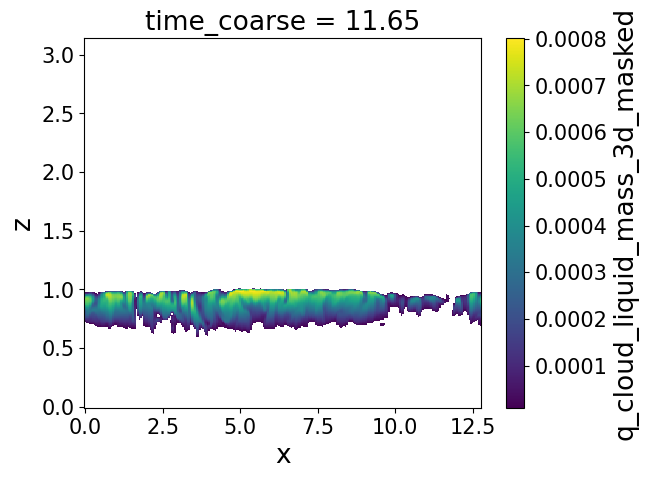

In [13]:
ppe.em0.ds.q_cloud_liquid_mass_3d_masked[6].plot(y='z')

In [8]:
ppe.em0.ds["z"] = ppe.em0.ds.z*1e-3

In [10]:
ppe.em0.ds.toa_down_SW_mean

<xarray.DataArray 'toa_down_SW_mean' (time_coarse: 46)> Size: 368B
[46 values with dtype=float64]
Coordinates:
  * time_coarse  (time_coarse) float64 368B 1.251 3.09 4.835 ... 69.36 70.98

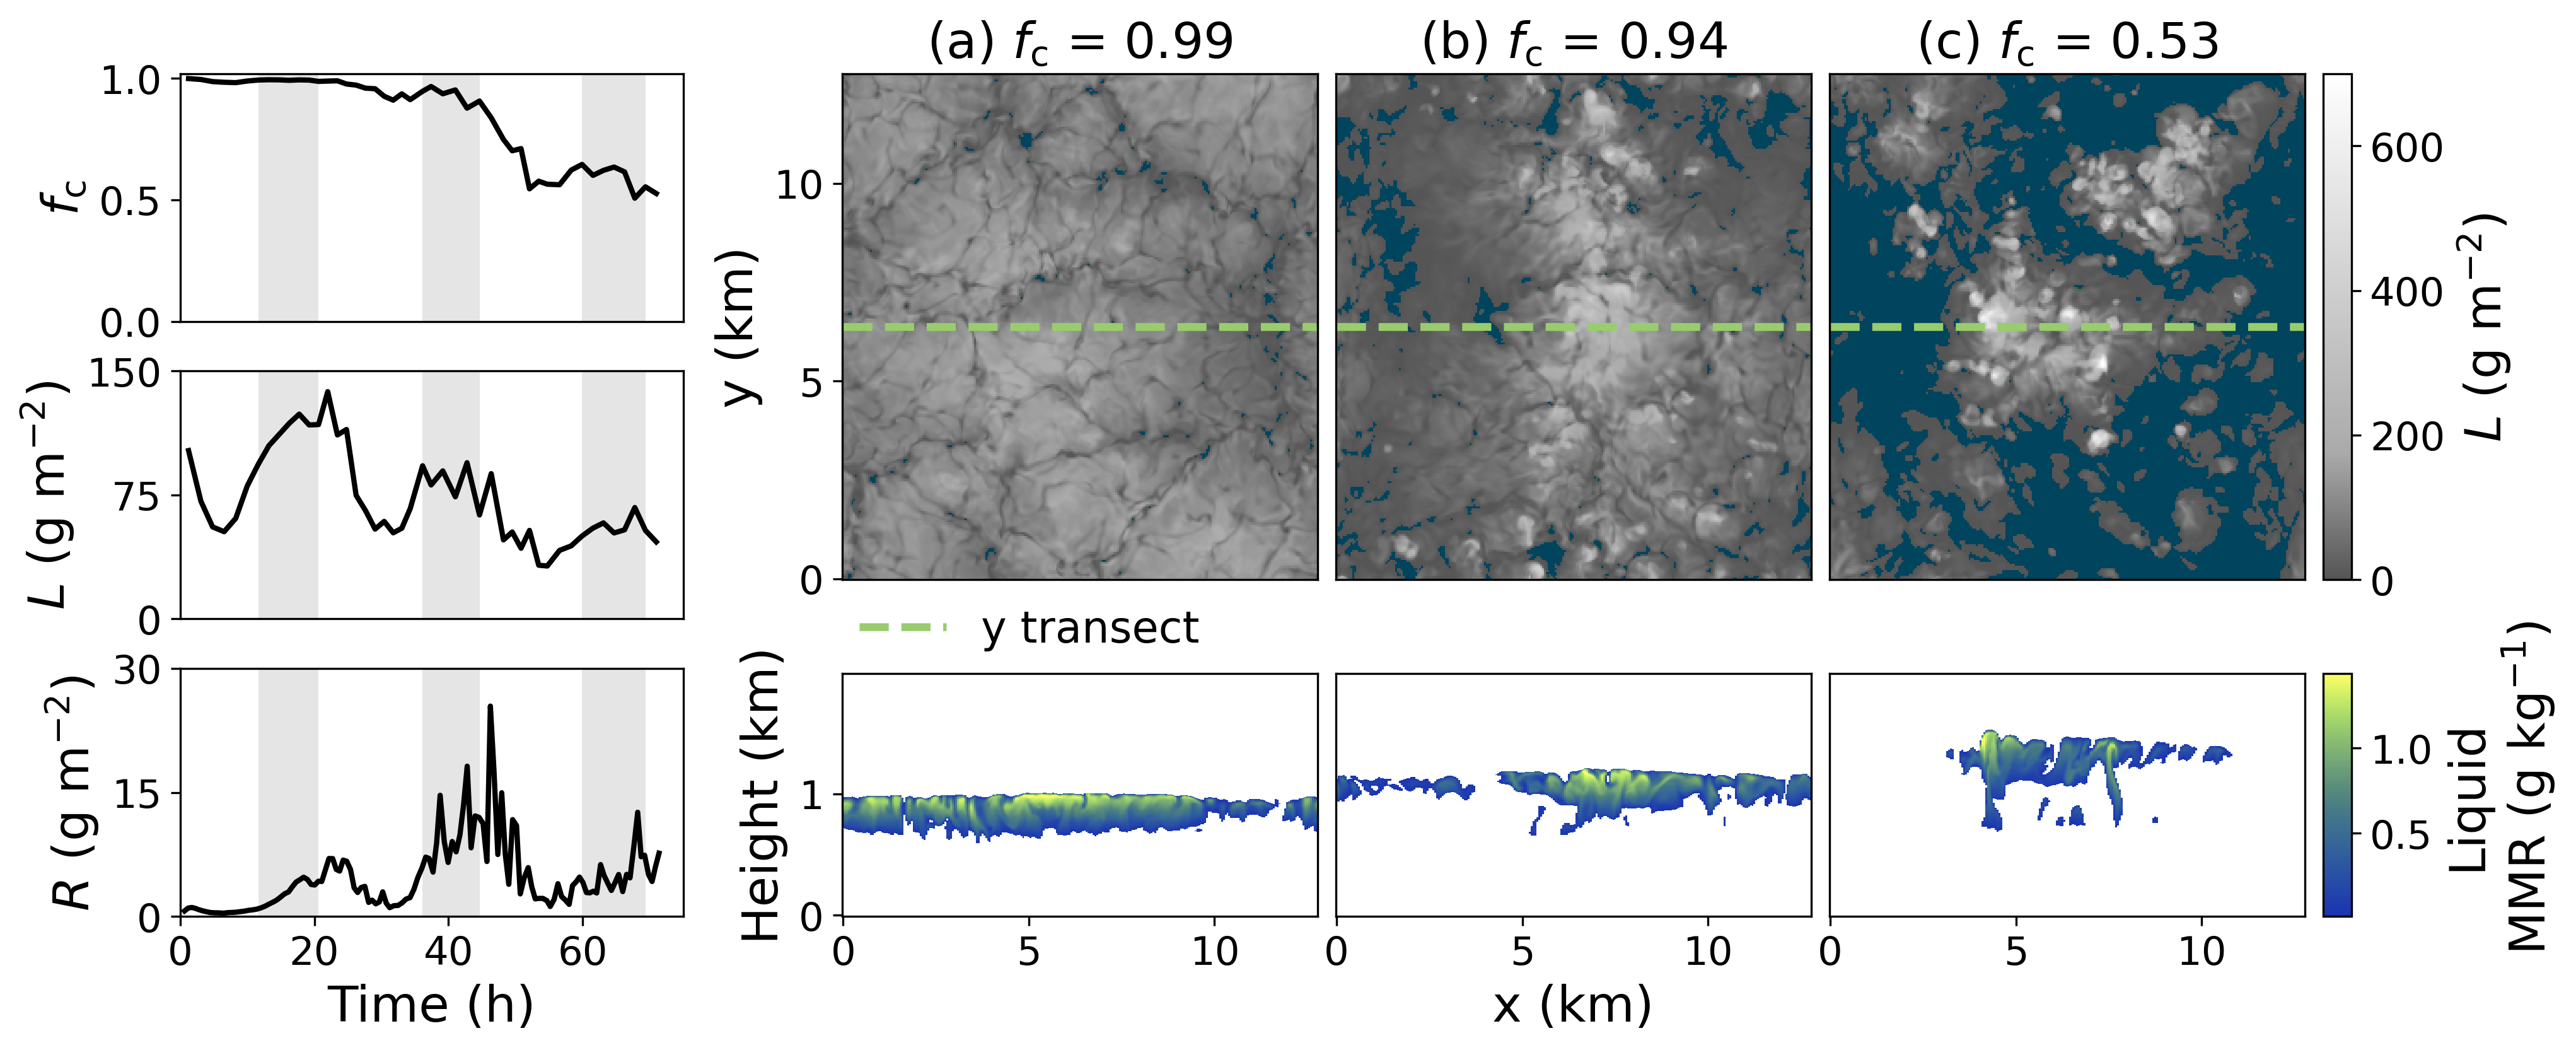

In [16]:
fig = plt.figure(figsize=(14,5.5),dpi=300)

# Create grid structure
# Snapshots
gs0 = gridspec.GridSpec(2, 4, figure=fig, height_ratios=(1,0.48), width_ratios=(1,1,1,0.06), hspace=0.25, wspace=0.05, left=0.33, right=0.9, top=0.92)
ax1 = fig.add_subplot(gs0[0])
ax2 = fig.add_subplot(gs0[1])
ax3 = fig.add_subplot(gs0[2])
ax4 = fig.add_subplot(gs0[4])
ax5 = fig.add_subplot(gs0[5])
ax6 = fig.add_subplot(gs0[6])
ax7 = fig.add_subplot(gs0[3])
ax8 = fig.add_subplot(gs0[7])
top = [ax1, ax2, ax3]
bottom = [ax4, ax5, ax6]

# Timeseries
gs1 = gridspec.GridSpec(3, 1, figure=fig, hspace=0.2, left=0.08, right=0.27, top=0.92)
ax1_1 = fig.add_subplot(gs1[0])
ax1_2 = fig.add_subplot(gs1[1])
ax1_3 = fig.add_subplot(gs1[2])

# Snapshot indices
indices = [6, 21, 45]

# Load LWP cmap 
cmap, norm = cl.load_topdown_lwp_cmap()

for a, i, letter in zip(top, indices, ['a','b','c']):
    c_obj1=ppe.em0.ds.lwp_mask_2d[i].plot(ax=a, x='x', y='y', cmap=cmap, norm=norm, add_colorbar=False)
    #c_obj1=a.pcolor(ppe.em0.ds.lwp_mask_2d[i,::2,::2], cmap=cmap, norm=norm)
    a.plot([0,ppe.em0.ds.x[-1]], [ppe.em0.ds.y[-1]/2, ppe.em0.ds.y[-1]/2], c=colors_list[7], linewidth=3, linestyle='--', label="y transect")
    a.set_title(f"({letter}) "+"$\mathit{f}_\mathrm{c}$"+f" = {ppe.em0.ds.cloud_frac[i].data:0.2f}",fontsize=LARGE_SIZE)
    a.xaxis.set_visible(False)
    a.yaxis.set_ticks([0,5,10])
    
    if i!=6:
        a.yaxis.set_visible(False)

for b, j in zip(bottom, indices):
    data=ppe.em0.ds.q_cloud_liquid_mass_3d_masked[j,:,:252]*1000
    c_obj2=data.plot(y='z',ax=b,add_colorbar=False,cmap=cmap1)
    b.set_title("")
    
    if j!=6:
        b.yaxis.set_visible(False)
        
    if j!=21:
        b.set_xlabel("")
        
ax4.set_ylabel("Height (km)")
ax5.set_xlabel("x (km)")
ax1.set_ylabel("y (km)")
        
c_obj=cm.ScalarMappable(norm=norm, cmap=cmap)
cbar1=fig.colorbar(c_obj, cax=ax7, shrink=0.5, anchor=(0.0,0.91))
cbar1.set_label('$\mathit{L}$ (g m$^{-2}$)')

cbar2=fig.colorbar(c_obj2, cax=ax8, shrink=0.6, anchor=(0.0,0.91))
cbar2.set_label('Liquid\n MMR (g kg$^{-1}$)',rotation=90)

# Add patch for transect
top[0].legend(loc=(0.0,-0.175),frameon=False)

for ax, output, ylabel, ylims, yticks in zip([ax1_1, ax1_2, ax1_3], [ppe.em0.ds.cloud_frac, ppe.em0.ds.cloudy_lwp, ppe.em0.ds.rwp*1e3], 
                                    ["$\mathit{f}_\mathrm{c}$", "$\mathit{L}$ (g m$^{-2}$)", "$\mathit{R}$ (g m$^{-2}$)"], [(0,1.02),(0,150),(0,30)],
                                    [[0.0,0.5,1.0], [0,75,150],[0,15,30]]):
    cl.add_diurnal(ppe.em0.ds, ax, ylims)
    ax.set_ylim(ylims)
    ax.yaxis.set_ticks(yticks)
    ax.set_xlim((0,75))
    output.plot(ax=ax, c='black', linewidth=2)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Time (h)")
    if ax!=ax1_3:
        ax.xaxis.set_visible(False)

fig.savefig("figures/base_simulation.pdf", facecolor='white', dpi=300)
fig.savefig("figures/base_simulation.png", facecolor='white', dpi=300)